In [47]:
import os, sys
from os import listdir
from os.path import isfile, join
import pydicom
from pydicom.dataset import Dataset, FileDataset, FileMetaDataset
import datetime
import h5py
import numpy as np
import torch
import matplotlib.pyplot as plt
import random

sys.path.append('/home/vanveen/ConvDecoder/')
from utils.transform import ifft_2d

In [35]:
def rss(arr):
    return torch.sqrt(torch.sum(torch.square(torch.abs(arr)), axis=1))

In [45]:
path_in = '/bmrNAS/people/dvv/multicoil_val/'
NUM_FILES = 2

files = [f for f in listdir(path_in) if isfile(join(path_in, f))]
files = random.choices(files, k=NUM_FILES)
len(files)

2

In [37]:
file = files[0]

f = h5py.File(path_in + file, 'r')
ksp = torch.from_numpy(f.get('kspace')[()])
img = rss(ifft_2d(ksp))

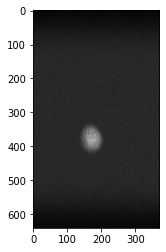

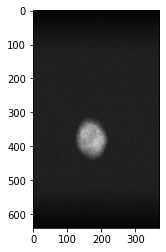

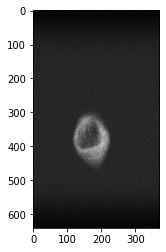

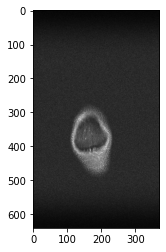

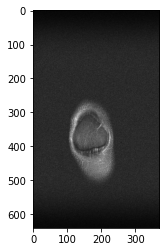

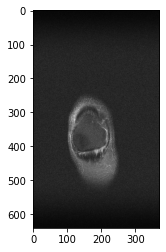

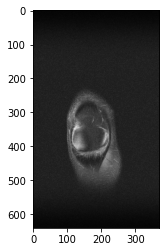

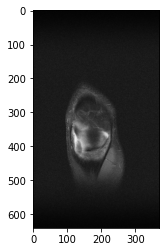

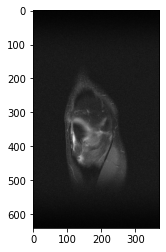

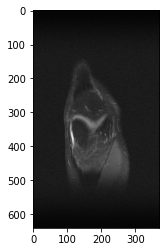

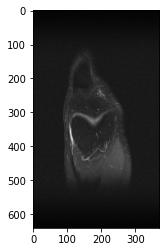

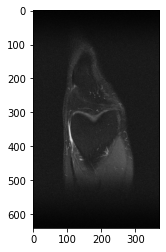

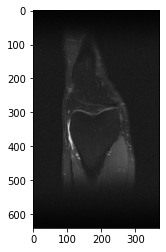

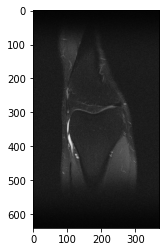

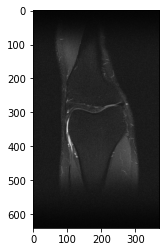

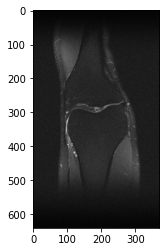

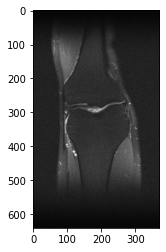

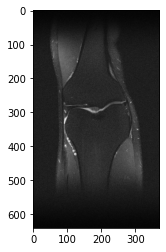

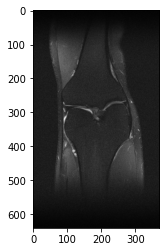

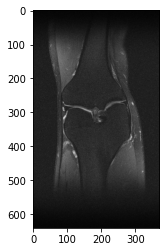

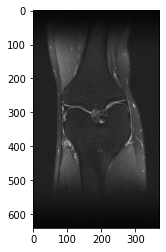

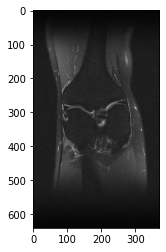

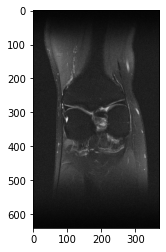

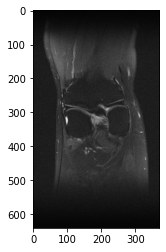

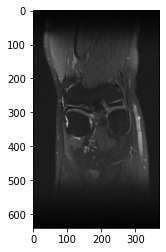

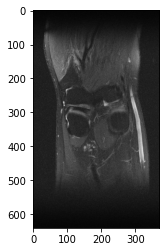

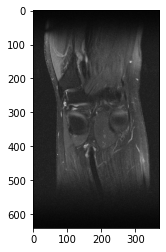

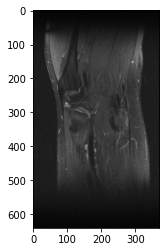

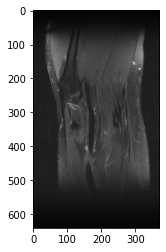

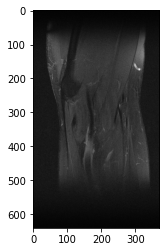

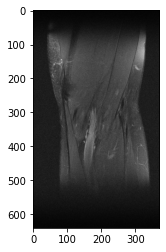

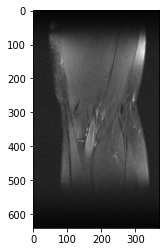

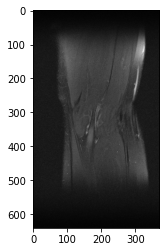

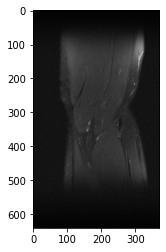

In [40]:
for im_slice in img:
    plt.imshow(im_slice, cmap='gray')
    plt.show()

### works for saving 2D slice, but how to save the entire 3D volume??

In [87]:
import pydicom
from pydicom.dataset import Dataset, FileDataset
from pydicom.uid import ExplicitVRLittleEndian
import pydicom._storage_sopclass_uids

img = np.array(img).astype(np.uint16)

meta = pydicom.Dataset()
meta.MediaStorageSOPClassUID = pydicom._storage_sopclass_uids.MRImageStorage
meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian  

ds = Dataset()
ds.file_meta = meta

ds.is_little_endian = True
ds.is_implicit_VR = False

ds.SOPClassUID = pydicom._storage_sopclass_uids.MRImageStorage
ds.PatientName = "Test^Firstname"
ds.PatientID = "123456"

ds.Modality = "MR"
ds.SeriesInstanceUID = pydicom.uid.generate_uid()
ds.StudyInstanceUID = pydicom.uid.generate_uid()
ds.FrameOfReferenceUID = pydicom.uid.generate_uid()

ds.BitsStored = 16
ds.BitsAllocated = 16
ds.SamplesPerPixel = 1
ds.HighBit = 15

ds.ImagesInAcquisition = img.shape[0] #"1"
# ds.DepthOfScanField = img.shape[2]
ds.Rows = img.shape[1]
ds.Columns = img.shape[2]
ds.InstanceNumber = 1

ds.ImagePositionPatient = r"0\0\1"
ds.ImageOrientationPatient = r"1\0\0\0\-1\0"
ds.ImageType = r"ORIGINAL\PRIMARY\AXIAL"

ds.RescaleIntercept = "0"
ds.RescaleSlope = "1"
ds.PixelSpacing = r"1\1"
ds.PhotometricInterpretation = "MONOCHROME2"
ds.PixelRepresentation = 1

pydicom.dataset.validate_file_meta(ds.file_meta, enforce_standard=True)

ds.PixelData = np.array(img)#img.tobytes()

ds.save_as(r"out.dcm")

Setting file meta information...
Setting pixel data...


In [88]:
ff = pydicom.read_file('out.dcm', force=True)
img_o =  ff.pixel_array

img.shape, img_o.shape

((34, 640, 372), (640, 372))

0

In [85]:
np.max(np.abs(np.array(img) - img_o))

0